# Projecting JunoCam images
Raw *JunoCam* images consist of several framelets, each corresponding to a different filter. As the spacecraft moves, the framelets correspond to different parts of the sky. To project the raw image to a map, we need to calculate the positions of each pixel in the image. 

Also be sure to compile the C script in the `projection/` folder. To do this, open the `projection/` folder in a terminal, and run `make`. 

Once those are done, import the projector functions. The first command points to the location of the `JunoCamProjection` module. 

In [1]:
import sys
sys.path.append('/home/rsankar/JunoCamProjection/')
from projection import projector
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The projection functions make use of the [SPICE toolkit](https://naif.jpl.nasa.gov/naif/toolkit.html) which read in kernel files that are produced by NAIF. These kernel files define the position of planets and spacecraft and are updated periodically. 

To project *JunoCam* data, we will need the Juno kernels. You can get these by using the `wget` command. Open a terminal, `cd` to the folder where you want the kernls to be, and enter the following command:
```bash
wget -m -nH --cut-dirs=3 -nv ftp://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/
```

This will create a `kernels/` folder and populate it with different kernels that define the *Juno* spacecraft and Jupiter. In the next cell, set `KERNEL_DATAFOLDER` to point to the `kernels` folder that was created. 

**WARNING: The downloaded data is in excess of 30 GBs. Make sure you have the disk space for it**

In [2]:
KERNEL_DATAFOLDER = '/home/rsankar/kernels/'

Now initialize the `Projector` class with the location of our image and metadata that's associated with it. *JunoCam* images can be downloaded from [the JunoCam Processing website](https://www.missionjuno.swri.edu/junocam/processing). To process the raw images, be sure to select the JUNOCAM filter so as to filter out user generated images. 

Click on the image, and download the images and metadata zips to this folder. Unzip them to produce the`ImageSet/` and `DataSet/` folders. Note the name of metadata file inside the `Dataset/` folder. 

We initialize the Projector class by inputting the folder containing the images (`ImageSet/`), the metadata file (`DataSet/xxxx-Metadata.json`) and the location of the kernels. This example shows the included GRS image from Perijove 27 (ID: 8724). 

In [3]:
proj = projector.Projector("ImageSet/", "DataSet/8724-Metadata.json", KERNEL_DATAFOLDER)

Once the object is initialized, we can project it. Call the `process` method, which can run in parallel with the `num_procs` argument. This call calculates the lat/lon of the center of each pixel in the original JunoCam framelet, correcting for barrel distortions (see Optical Distortions section [here](https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/ik/juno_junocam_v03.ti)) and for interframe delay. The code also automatically determines the best value for the jitter in the image start time by fitting the limb of the planet (see timing note [here](https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/ik/juno_junocam_v03.ti)). 

Note: This will take some time (5-10 mins), so you can go grab something to drink. Also, **be sure to change the number of processors as needed**.  

In the end, the code will produce a netCDF4 file which contains the location of each pixel, the time/location of the spacecraft for each framelet and a illumination-geometry corrected image. The name of this file is given by the `FILE_NAME` attribute in the metadata file which can be accessed via `proj.fname`. 

In [4]:
proj.process(num_procs=10)

JNCE_2020154_27C00047_V01
Projecting framelets:
Found best jitter value of -23.0 ms
[=================== ] 97.44%
Extents - lon: -84.087 105.134 lat: -80.006 1.832 - lowest pixres: 0.020 deg/pix


So now, we will need to combine the framelets so that we can get a 'map-projected' image. Ideally this should be in one of the [standard cartographic projections](https://en.wikipedia.org/wiki/List_of_map_projections#pseudocylindrical) but, for now, we'll just use a lon/lat grid.

To project the map, we need to define our grid. The `proj` object defined above calculates the extent of the image. These can be determined from the object attributes (`lonmin`, `lonmax`, `latmin`, `latmax`) and we can create a uniform spacing between them. 

Once these are created, we call the `map_project` function and use the input the newly generated netCDF4 file. This code can be parallelized with the `num_procs` option as before, and use `save=True` if you want to save the RGB frames to a PNG file and the mosaic to a netCDF4 file (`filename`_proj.nc where `filename` is the `proj.fname` attribute as before). 

We can provide extents for the final map, or let the code automatically determine the bounds of the mosaic. If you want to let the code determine this automatically, you must provide a pixel resolution using the `pixres` argument (units of degrees/pixel). 

If you want pass in specific bounds, define the arrays for the latitude and longitude extents:
```python
latg = np.arange(-10, 10, 1./25.) # latitude range -10 to +10 at 25 pixels per degree
long = np.arange(-30, 30, 1./25.) # longitude range -30 to +30 at 25 pixels per degree
datafile, IMG, mask = projector.map_project("%s.nc"%proj.fname, latg=latg, long=long, ...)
```

This step will also take a few minutes. 

In [5]:
resolution=25 ## pixels/degree
datafile, IMG, mask = projector.map_project(f"{proj.fname}.nc", pixres=1./resolution, save=True, num_procs=10)

Projecting JNCE_2020154_27C00047_V01
Using raw IMG
Limits: lon: -84.087 90.713  lat: -80.006 1.794  size: 4371 x 2046
 2000/2046 Processing B
 19/20
[=================== ] 97.20%
Processing G
 19/20
[=================== ] 97.19%
Processing R
 19/20
[=================== ] 97.17%
Processing emission angles
 19/20
[=================== ] 97.23%
Processing incidence angles
 19/20
[=================== ] 97.23%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


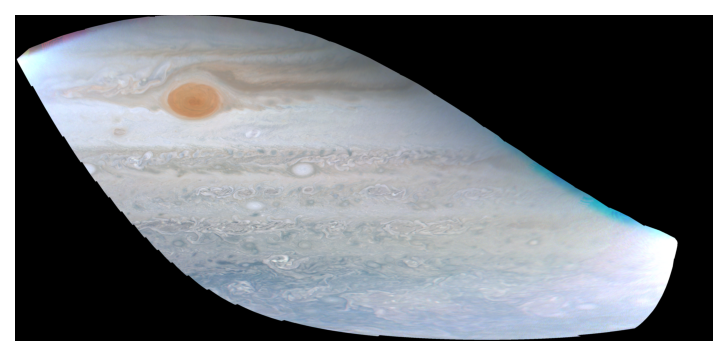

In [6]:
plt.figure(dpi=150)
plt.imshow(IMG/np.percentile(IMG.flatten(), 99), origin='lower')
plt.axis('off')
plt.show()

This function returns the name of netCDF file where the projected data is stored, the projected RGB image and the image mask (which shows which pixels in the mosaic contain data). By default the code performs a simple Lambertian lighting correction to remove image gradients, but this is usually not enough to smoothen out the lighting. You can turn this correction using `scorr_method='None'`. 

There are 3 options:

 - 'simple': applies a Lambertian correction (i.e. divides each pixel by cosine of the incidence angle). This is usually not robust enough for mosaicing and should be avoided.
 
 - 'poly': does a bi-variate 5th order polynomial fit to the lighting variation as a function of cosine of incidence and emission angles. Based on [Gerald Eichstadt's talk during EPSC 2017](http://junocam.pictures/gerald/talks/epsc2017-517_v01/epsc2017_am2_517_eichstaedt_v01.pdf). 
 
 - 'fft': Applies a high-pass filter to the image's brightness values, so that large scale (low frequency) brightness variations are removed. This works by performing a Gaussian blur across the entire brightness channel of the image, and dividing the image by the blurred filter. Works well across the entire globe, but sensitive to input parameters. Requires three parameters: 
     - `fft_radius` which is effectively the frequency threshold. This is the radius of the Gaussian blur. Smaller values preserve high frequency (small scale) information, while larger values blur smaller scale features. A value of 7 is usually good. Turn it down if you are losing sharpness of features. 
     - `trim_rad` which is used to trim edges from the processed image (edges are high frequency modes and face issues from Gibbs' phenomenon). This is a multiplicative factor on the `fft_radius` and a value of less than 1 will trim more pixels from the edges of the image. If your images show bright sharp edges, decrease this value. 
     - `trim_thresh` is the threshold to trim edges (accepted values are 0-1). A value close to 1 will trim more pixels, while a lower value will trim further out. A value of `0.98` is usually good. Reduce if you are losing too much of the image, and increase if the edge artifacts are not being removed (try with `trim_rad` above first, though)

Let's redo the same processing with the FFT option. I find that 5-10 is a good value for `fft_radius` to capture small details but remove large scale variations. Since we defined `save=True` above, we can just load in the projected image (using `load=True`), and rerun the code with the new correction:

In [7]:
resolution=25 ## pixels/degree
datafile, IMG, mask = projector.map_project(f"{proj.fname}.nc", pixres=1./resolution, save=True, num_procs=10,
                                           scorr_method='fft', fft_radius=8, load=True)


Projecting JNCE_2020154_27C00047_V01
Using raw IMG
Limits: lon: -84.087 90.713  lat: -80.006 1.794  size: 4371 x 2046
Loading mask file
Processing B
Loading from ./npy/JNCE_2020154_27C00047_V01_B.npy
Processing G
Loading from ./npy/JNCE_2020154_27C00047_V01_G.npy
Processing R
Loading from ./npy/JNCE_2020154_27C00047_V01_R.npy
Loading emission data
Loading incidence data


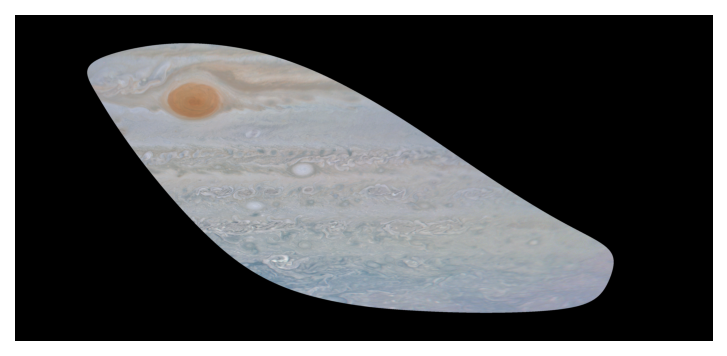

In [8]:
plt.figure(dpi=150)
plt.imshow(IMG/IMG.max(), origin='lower')
plt.axis('off')
plt.show()

Finally, we do a basic color correction, normalization and gamma correction to the image. You can save out the new image to a PNG file (with filename given by the `fname` argument) with `save=True`. This will create a `[fname]_mosaic_RGB.png` in the `mos/` folder. 

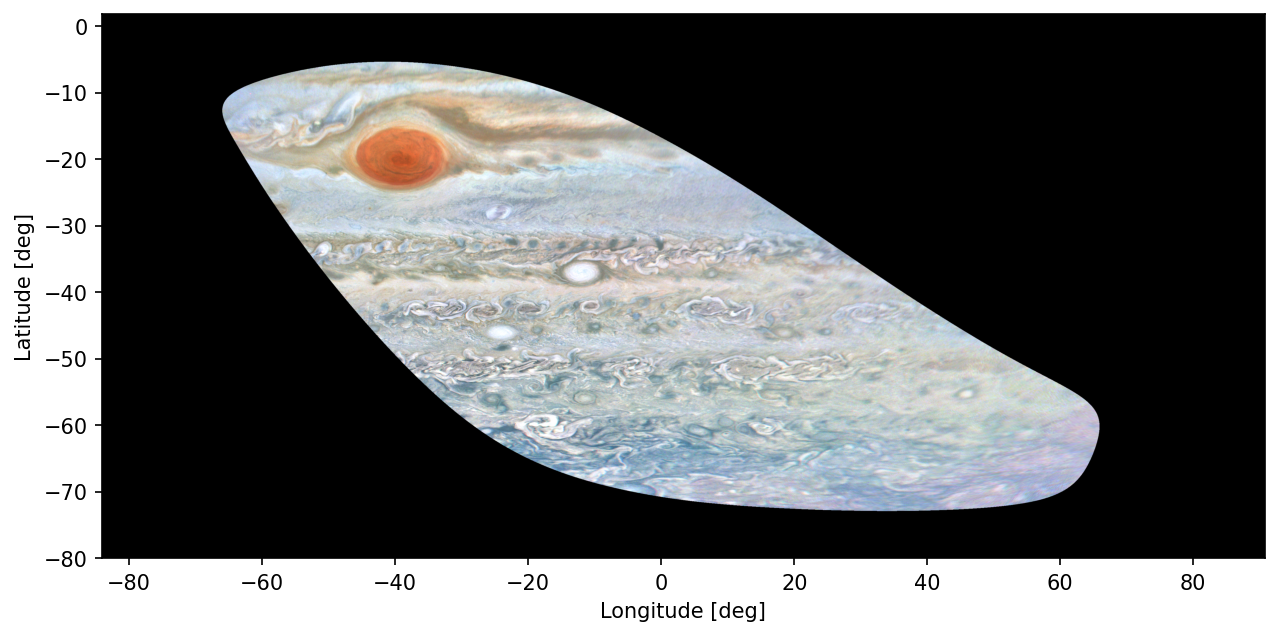

In [9]:
IMG_corr = projector.color_correction(f"nc/{datafile}", gamma=1.1, hist_eq=True, clip_limit=0.008, 
                                      fname=proj.fname, save=True)

We can also plot this in an orthographic projection (i.e. similar to what the spacecraft might have seen). The `sat_height_scale` defines how high above the surface your viewpoint is. Lower values bring you closer, but increases the 'fish-eye' effect. 

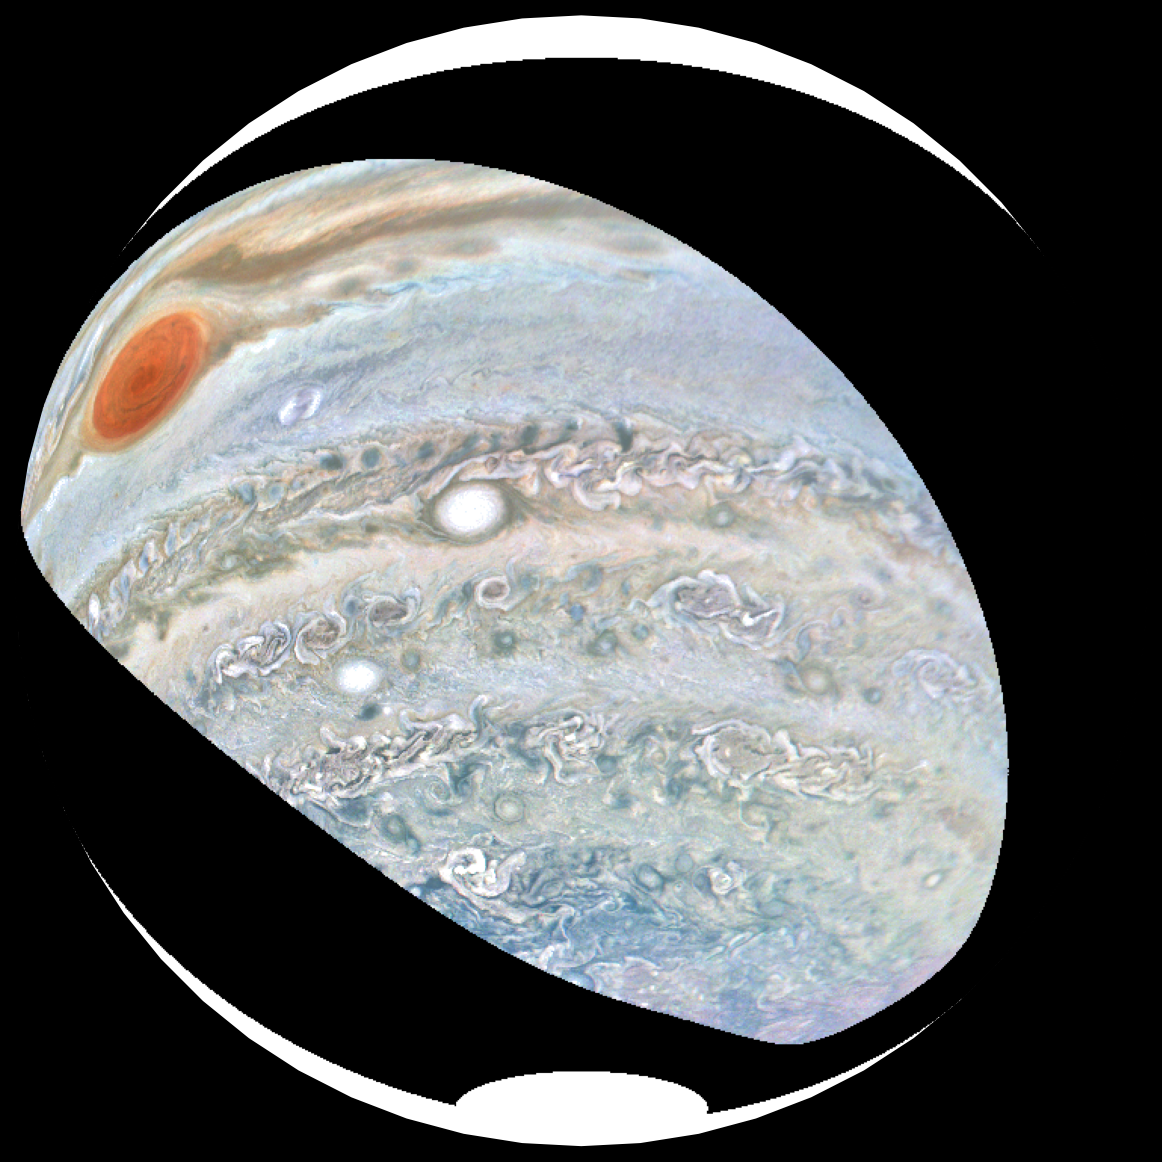

In [10]:
projector.plot_ortho(f"nc/{datafile}", sat_height_scale=0.2)